# Airline Tweet Classification and Sentiment Analysis Using Deep Learning (CNN, CNN-LSTM, Word/Character-based Embeddings)

This data originally came from Crowdflower's Data for Everyone library.https://www.figure-eight.com/data-for-everyone/ <BR>

As the original source says,<BR>

A sentiment analysis job about the problems of each major U.S. airline. Twitter data was scraped from February of 2015 and contributors were asked to first classify **positive**, **negative**, and **neutral** tweets, followed by categorizing negative reasons (such as "late flight" or "rude service").<BR>

In this Notebook, we will go step by step from multi-class Classification perspective of these text sequences (first part). We will perform 
-  Exploratory Data Analysis
-  Data Preprocessing
-  Basic CNN Frameworks with word embeddings, character embeddings and ensembles with LSTM
-  Hidden layers visualization for CNN and plotting using PCA and TSNE
-  False Positive and False Negative Analysis for CNN 
-  Model Explanation(s) using SHAP for Deep Learning Models
-  Model Explanation (s) using LIME

Note: We evaluate and understand most CNN based architectures that have been published till 2018.



In [3]:
#import packages and verify versions

# numpy
import numpy
print('numpy: %s' % numpy.__version__)
# scipy
import scipy
print('scipy: %s' % scipy.__version__)
# matplotlib
import matplotlib
print('matplotlib: %s' % matplotlib.__version__)
# pandas
import pandas
print('pandas: %s' % pandas.__version__)
# nltk
import nltk
print('nltk: %s' % nltk.__version__)
# scikit-learn
import sklearn
print('sklearn: %s' % sklearn.__version__)
# wordcloud
import wordcloud
print('wordcloud: %s' % wordcloud.__version__)
# keras
import keras
print('keras: %s' % keras.__version__)
# tensorflow
import tensorflow
print('tensorflow: %s' % tensorflow.__version__)

numpy: 1.15.4
scipy: 0.19.1
matplotlib: 2.1.0
pandas: 0.20.3
nltk: 3.2.4
sklearn: 0.19.1
wordcloud: 1.4.1
keras: 2.2.4
tensorflow: 1.12.0


In [1]:
# Basic packages
import pandas as pd 
import numpy as np
import re
import collections
import time
import matplotlib.pyplot as plt



# Packages for data preparation
from sklearn.model_selection import train_test_split,StratifiedKFold, cross_val_score
from nltk.corpus import stopwords
from keras.preprocessing.text import Tokenizer
from keras.utils.np_utils import to_categorical
from keras.utils.vis_utils import plot_model
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import average_precision_score, precision_recall_curve, confusion_matrix

# Packages for modeling
from keras import models
from keras import layers
from keras import regularizers

# Word cloud visualization libraries
from scipy.misc import imresize
from PIL import Image
from wordcloud import WordCloud, ImageColorGenerator, STOPWORDS
from collections import Counter

import itertools

from keras.wrappers.scikit_learn import KerasClassifier

# Packages for Sequence and CNN based layers
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential, Model, load_model
from keras.layers.embeddings import Embedding
from keras.layers import Flatten, Dense, Dropout, AlphaDropout, ThresholdedReLU, Convolution1D, ZeroPadding1D, Activation, MaxPooling1D, SpatialDropout1D, Input 
from keras.layers import GlobalMaxPooling1D, concatenate, LSTM, Bidirectional,BatchNormalization
from keras.optimizers import Adam
from keras.utils import np_utils
from keras.callbacks import ModelCheckpoint, EarlyStopping,TensorBoard

/Users/udaykamath/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# Global Parameters and Constants

In [2]:
# location of data
DATA_FILE = './data/Tweets.csv'

# data columns for learning
TEXT_COLUMN_NAME = 'text'
LABEL_COLUMN_NAME = 'airline_sentiment'

# EMBEDDINGS FILE 
GLOVE_EMBEDDINGS_FILE = 'embeddings/glove.6B.100d.txt'
FASTTEXT_EMBEDDINGS_FILE = 'embeddings/wiki-news-300d-1M.vec'

# parameters for learning
# Parameter indicating the number of words we'll put in the dictionary
# (change it per source)
NB_WORDS = 10000
VAL_SIZE = 1000  # Size of the validation set
NB_EPOCHS = 20  # Number of epochs
BATCH_SIZE = 512  # Size of the batches used in the mini-batch gradient descent
# Maximum number of words in a sequence (see the sentence distribution)
MAX_LEN = 24
EMBEDDING_DIM = 100  # Number of dimensions of the GloVe word embeddings
FASTTEXT_EMBEDDING_DIM = 300  # Number of dimensions of the FastText word embeddings
MAX_SENT_LEN = 300  # character based length
MAX_DOC_LEN = 5  # Number of sentences in text

# labels
labels = ['negative', 'neutral', 'positive']


# 1. Exploratory Data Analysis

## 1.1 Loading the data in Pandas DataFrame

In [3]:
# read the file
tweets = pd.read_csv(DATA_FILE)
tweets = tweets.reindex(np.random.permutation(tweets.index))  
# only the text and labels
tweets = tweets[[TEXT_COLUMN_NAME, LABEL_COLUMN_NAME]]
# get a peek of the data
tweets.head()

,text,airline_sentiment
8245,@JetBlue Guess I'll wait another 24 hrs in hop...,neutral
4993,@SouthwestAir waiting over a half hour for my ...,negative
8428,"@JetBlue Gains Altitude, But SkyWest Hits Turb...",neutral
239,@VirginAmerica sounds like fun !,positive
12062,@AmericanAir I purchased Main Cabin XT for f-1...,negative


## 1.2 Target distribution analysis

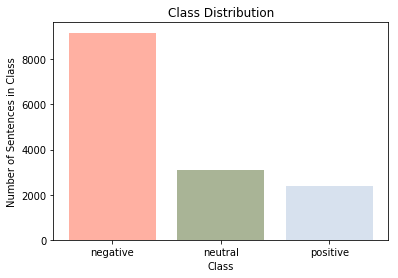

In [7]:
text = tweets[TEXT_COLUMN_NAME]
sentiments = tweets[LABEL_COLUMN_NAME]

# unique labels
sentiments.unique()
# group by
grouped = tweets.groupby([LABEL_COLUMN_NAME])[TEXT_COLUMN_NAME].count()
plt.bar(
    labels,
    grouped.values,
    align='center',
    color=[
        'tomato',
        'darkolivegreen',
        'lightsteelblue'],
    alpha=0.5)
plt.ylabel('Number of Sentences in Class')
plt.xlabel('Class')
plt.title('Class Distribution')

plt.show()

## 1.3 Text Length Frequency Per Class

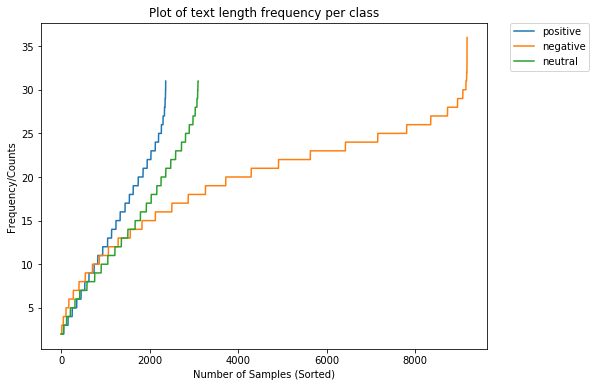

In [8]:
# Set of unique label
lbl_set = list(set(sentiments))


def length_counter(all_label, all_text, class_name):

    class_txt = []

    # Seperate all lines for a class
    for lbl, txt in zip(all_label, all_text):
        if lbl == class_name:
            class_txt.append(txt)

     # Count words per line of that class
    line_word_count = []
    for k in range(len(class_txt)):
        line_words = class_txt[k].lower().split()
        line_word_count.append(len(line_words))

    return np.sort(line_word_count)


plt.figure(figsize=[8, 6])
for lbl in lbl_set:
    count = length_counter(sentiments, text, lbl)
    plt.plot(np.arange(1, len(count) + 1, 1), count, label=lbl)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title("Plot of text length frequency per class")
plt.xlabel("Number of Samples (Sorted)")
plt.ylabel("Frequency/Counts")
plt.show()


## 1.4 Number of Words distribution

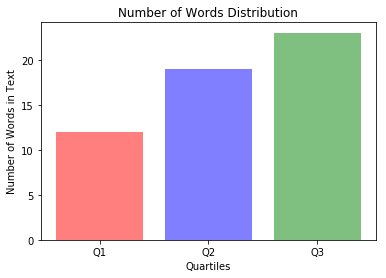

In [0]:
# ADD WORDS DERIVED COLUMN
NUMBER_OF_WORDS_COLUMN = TEXT_COLUMN_NAME + 'NB_WORDS_COLUM'
tweets[NUMBER_OF_WORDS_COLUMN] = tweets[TEXT_COLUMN_NAME].str.split().apply(len)
data = tweets[NUMBER_OF_WORDS_COLUMN].describe()

quartiles = ['Q1', 'Q2', 'Q3']
top = [data['25%'], data['50%'], data['75%']]
plt.bar(
    quartiles,
    top,
    align='center',
    color=[
        'red',
        'blue',
        'green'],
    alpha=0.5)
plt.ylabel('Number of Words in Text')
plt.xlabel('Quartiles')
plt.title('Number of Words Distribution')

plt.show()

## 1.5 Word Cloud for Positive and Negative Sentiments


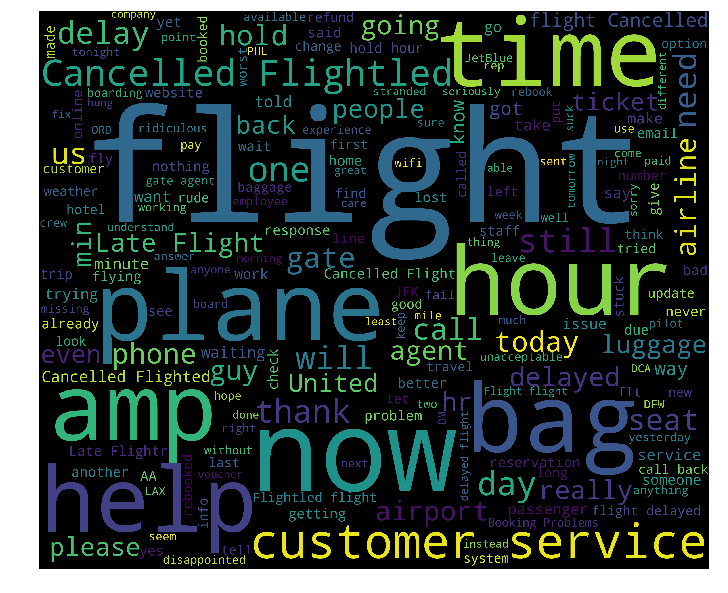

In [0]:
negative_df = tweets[tweets[LABEL_COLUMN_NAME] == 'negative']
words = ' '.join(negative_df[TEXT_COLUMN_NAME])
negative_cleaned_words = " ".join([word for word in words.split()
                                   if 'http' not in word
                                   and not word.startswith('@')
                                   and word != 'RT'
                                   ])
wordcloud = WordCloud(stopwords=STOPWORDS,
                      background_color='black',
                      width=3000,
                      height=2500
                      ).generate(negative_cleaned_words)
plt.figure(1, figsize=(12, 12))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

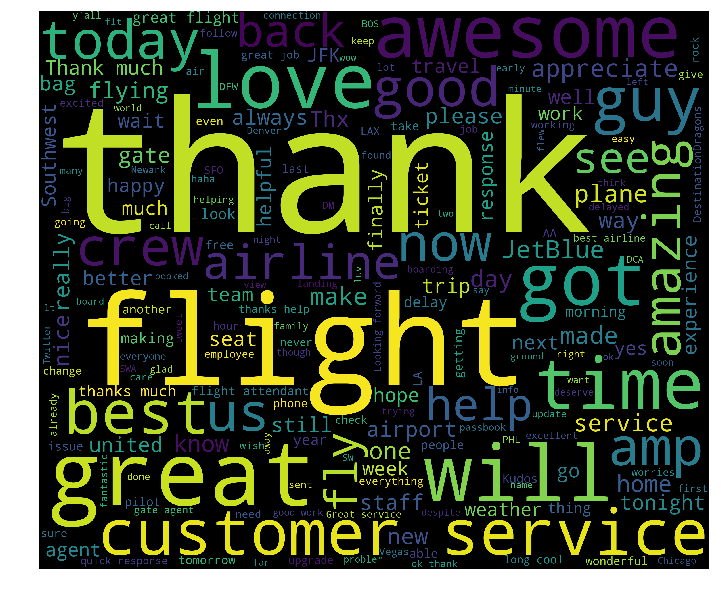

In [0]:
positive_df = tweets[tweets[LABEL_COLUMN_NAME] == 'positive']
all_positive_words = ' '.join(positive_df[TEXT_COLUMN_NAME])
positive_cleaned_words = " ".join([word for word in all_positive_words.split()
                                   if 'http' not in word
                                   and not word.startswith('@')
                                   and word != 'RT'
                                   ])
wordcloud = WordCloud(stopwords=STOPWORDS,
                      background_color='black',
                      width=3000,
                      height=2500
                      ).generate(positive_cleaned_words)
plt.figure(1, figsize=(12, 12))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()


# 2. DATA Preproessing 

## 2.1 Stop words and mentions removal

In [4]:
# remove stop words with exceptions
def remove_stopwords(input_text):
    stopwords_list = stopwords.words('english')
    # Some words which might indicate a certain sentiment are kept
    white_list = ["n't", "not", "no"]
    words = input_text.split()
    clean_words = [word for word in words if (
        word not in stopwords_list or word in white_list) and len(word) > 1]
    return " ".join(clean_words)
# remove mentions


def remove_mentions(input_text):
    return re.sub(r'@\w+', '', input_text)


tweets = tweets[[TEXT_COLUMN_NAME, LABEL_COLUMN_NAME]]
tweets[TEXT_COLUMN_NAME] = tweets[TEXT_COLUMN_NAME].apply(
    remove_stopwords).apply(remove_mentions)
tweets.head()

,text,airline_sentiment
8245,Guess I'll wait another 24 hrs hopes rate goe...,neutral
4993,waiting half hour checked baggage delivered! ...,negative
8428,"Gains Altitude, But SkyWest Hits Turbulence J...",neutral
239,sounds like fun,positive
12062,purchased Main Cabin XT f-1571AUS. Flight Can...,negative


## 2.2 Split dataset in Training and Testing (unseen)

In [5]:
X_train_entire, X_test, y_train_entire, y_test = train_test_split(
    tweets[TEXT_COLUMN_NAME], tweets[LABEL_COLUMN_NAME], test_size=0.15, random_state=37)
print('# Train data samples:', X_train_entire.shape[0])
print('# Test data samples:', X_test.shape[0])
assert X_train_entire.shape[0] == y_train_entire.shape[0]
assert X_test.shape[0] == y_test.shape[0]


# Train data samples: 12444
# Test data samples: 2196


## 2.3 Tokenize the dataset on training data

In [6]:
# tokenization with max words defined and filters
tk = Tokenizer(num_words=NB_WORDS,
               filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
               lower=True,
               split=" ")
tk.fit_on_texts(X_train_entire)

print('Fitted tokenizer on {} documents'.format(tk.document_count))
print('{} words in dictionary'.format(tk.num_words))

Fitted tokenizer on 12444 documents
10000 words in dictionary


## 2.4 Sentence Distribution in training data

In [7]:
# understand the sequence distribution for max length 
seq_lengths = X_train_entire.apply(lambda x: len(x.split(' ')))
seq_lengths.describe()

count    12444.000000
mean        11.140228
std          4.230674
min          1.000000
25%          8.000000
50%         12.000000
75%         14.000000
max         24.000000
Name: text, dtype: float64

## 2.5 Convert Train and Test to fixed length sequences

In [8]:
# convert train and test to sequence using the tokenizer
X_train_entire_seq_tok = tk.texts_to_sequences(X_train_entire)
X_test_seq_tok = tk.texts_to_sequences(X_test)

# pad the sequences 
X_train_entire_seq = pad_sequences(X_train_entire_seq_tok, maxlen=MAX_LEN)
X_test_seq = pad_sequences(X_test_seq_tok, maxlen=MAX_LEN)

# perform encoding of 
le = LabelEncoder()
y_train_le = le.fit_transform(y_train_entire)
y_test_le = le.transform(y_test)
y_train_one_hot = to_categorical(y_train_le)
y_test_one_hot = to_categorical(y_test_le)


# labels from encoder mapping 
TARGET_TEXT_LABELS = le.classes_
TEXT_LABELS = le.classes_

## 2.6 Validation Dataset from Training

In [9]:
X_train_seq, X_valid_seq, y_train, y_valid = train_test_split(
    X_train_entire_seq, y_train_one_hot, test_size=0.15, random_state=37)

assert X_valid_seq.shape[0] == y_valid.shape[0]
assert X_train_seq.shape[0] == y_train.shape[0]

print('Shape of training set:', X_train_seq.shape)
print('Shape of validation set:', X_valid_seq.shape)

Shape of training set: (10577, 24)
Shape of validation set: (1867, 24)


# 3. Model Building

## 3.1 Utilities for training, logging and testing

In [10]:
def get_predictions_and_confidences(model, X_test, y_test):
    """
    return the predictions and confidences on the test set
    :param model: the Keras Classifier Model
    :param X_test: test sequences
    :param y_test: labels
    :return: a list of actual labels
    """
    y_softmax = model.predict(X_test)
    y_class_index = []
    y_pred_index = []
    confidence = []

    for i in range(len(y_test)):
        probs = y_test[i]
        index_arr = np.nonzero(probs)
        one_hot_index = index_arr[0].item(0)
        y_class_index.append(one_hot_index)

    for i in range(0, len(y_softmax)):
        probs = y_softmax[i]
        predicted_index = np.argmax(probs)
        y_pred_index.append(predicted_index)
        confidence.append(probs[predicted_index])
    return y_class_index, y_pred_index, confidence, y_softmax


def train_model(model, X_train, y_train, X_valid, y_valid):
    """
    This function trains the deep model using the training set and valdiation set.

    :param model: the Keras Classifier Model
    :param X_train: train sequences
    :param y_train: trian labels
    :return: a list of actual labels

    """
    start = time.time()
    checkpoints = []
    model.compile(
        optimizer=Adam(),
        loss='categorical_crossentropy',
        metrics=['accuracy'])
    checkpoint_file = './Checkpoints/Train-' + model.name + '-best_weights.h5'
    checkpoints.append(
        ModelCheckpoint(
            checkpoint_file,
            monitor='val_loss',
            verbose=0,
            save_best_only=True,
            save_weights_only=True,
            mode='auto',
            period=1))
    checkpoints.append(
        TensorBoard(
            log_dir='./logs',
            histogram_freq=0,
            write_graph=True,
            write_images=False,
            embeddings_freq=0,
            embeddings_layer_names=None,
            embeddings_metadata=None))
    checkpoints.append(EarlyStopping(monitor='val_loss', patience=10))

    history = model.fit(
        X_train,
        y_train,
        epochs=NB_EPOCHS,
        batch_size=BATCH_SIZE,
        validation_data=(
            X_valid,
            y_valid),
        verbose=1,
        callbacks=checkpoints)
    # load the weights from the checkpoint file, the best weights
    model.load_weights(checkpoint_file)
    end = time.time()
    total_time = end - start
    print("Model Training and Validation time %s secs" % (total_time))
    return history


def eval_metric(history, metric_name):

    metric = history.history[metric_name]
    val_metric = history.history['val_' + metric_name]

    e = range(1, NB_EPOCHS + 1)

    plt.plot(e, metric, color='navy', label='Train ' + metric_name)
    plt.plot(e, val_metric, color='red', label='Validation ' + metric_name)
    plt.xlabel('Epochs')
    plt.ylabel(metric_name)
    plt.legend()
    plt.show()

# This utility function is from the sklearn docs:
# http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


def test_model(model, X_test, y_test):
    start = time.time()
    # checkpoint
    checkpoint_file = './Checkpoints/Train-' + model.name + '-best_weights.h5'
    model.load_weights(checkpoint_file)
    results = model.evaluate(X_test, y_test)
    end = time.time()
    y_class_index, y_pred_index, confidence, y_softmax = get_predictions_and_confidences(
        model, X_test, y_test)
    cnf_matrix = confusion_matrix(y_class_index, y_pred_index)
    plt.figure(figsize=(6, 5))
    plot_confusion_matrix(
        cnf_matrix,
        classes=TEXT_LABELS,
        title="Confusion matrix")
    plt.show()
    total_time = end - start
    print("Model Training and Testing time : %s secs" % (total_time))
    print("Model Testing Accuracy : %s " % (results[1]))
    average_precision = average_precision_score(
        y_test, y_softmax, average='weighted')
    print('Average precision score: {0:0.2f}'.format(
        average_precision))
    return results


def test_model_runs(
        model,
        X_train,
        y_train,
        X_test,
        y_test,
        epoch_stop=20,
        num_runs=3,
        verbose=0):

    sum_result = 0
    sq_sum_result = 0
    for val in range(0, num_runs):
        base_results = test_model(
            model,
            X_train,
            y_train,
            X_test,
            y_test,
            epoch_stop,
            verbose)
        sum_result = sum_result + base_results[1]
        sq_sum_result = sq_sum_result + base_results[1] * base_results[1]
    mean_accuracy = sum_result / num_runs
    variance = sq_sum_result / num_runs - mean_accuracy * mean_accuracy
    stddev = variance**(.5)
    return mean_accuracy, stddev


def compare_loss(history, base_history, model_name, base_history_name):
    loss_base_model = base_history.history['val_loss']
    loss_model = history.history['val_loss']

    e = range(1, NB_EPOCHS + 1)

    plt.plot(e, loss_base_model, 'bo', label=base_history_name)
    plt.plot(e, loss_model, 'red', label=model_name)
    plt.legend()
    plt.xlabel('Epochs')
    plt.ylabel('loss')
    plt.show()


def read_embedding(path):

    embeddings_index = {}
    f = open(path)
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
    f.close()

    return embeddings_index


def create_embedding_matrix(tokenizer, embedding_dim, embeddings_index):

    word_index = tokenizer.word_index
    if tokenizer.num_words:  # if num words is set, get rid of words with too high index
        word_index = {key: word_index[key] for key in word_index.keys()
                      if word_index[key] < (tokenizer.num_words + 1)}
    embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
    for word, i in word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            # words not found in embedding index will be all-zeros.
            embedding_matrix[i] = embedding_vector

    return embedding_matrix


## 3.2 Experiments 

### 3.2.1 Experiment 1- Basic CNN Block Experiment 

Instructions for updating:
`NHWC` for data_format is deprecated, use `NWC` instead
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 24, 100)           1000000   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 24, 64)            19264     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 12, 64)            0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 768)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               76900     
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 303       
Total params: 1,096,467
Trainable params: 1,096,467
Non-tra

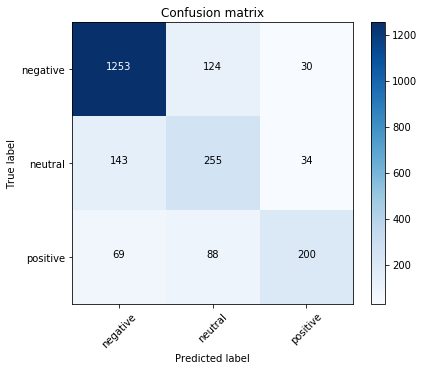

Model Training and Testing time : 0.12047839164733887 secs
Model Testing Accuracy : 0.7777777779949168 
Average precision score: 0.82


[0.6443278872575916, 0.7777777779949168]

In [0]:
# base cnn model
def base_cnn_model():
    model = Sequential(
        [
            Embedding(
                input_dim=NB_WORDS,
                output_dim=EMBEDDING_DIM,
                input_length=MAX_LEN),
            Convolution1D(
                filters=64,
                kernel_size=3,
                padding='same',
                activation='relu'),
            MaxPooling1D(),
            Flatten(),
            Dense(
                100,
                activation='relu'),
            Dense(
                3,
                activation='softmax')])
    model.name = 'BaseCNN'
    model.summary()
    return model


# train and validate
base_cnn_model = base_cnn_model()
base_history = train_model(
    base_cnn_model,
    X_train_seq,
    y_train,
    X_valid_seq,
    y_valid)
# train the entire training data and test on test data on base model
test_model(base_cnn_model, X_test_seq, y_test_one_hot)


### 3.2.2 Experiment 2 - Basic CNN + Dropout/Regularization

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 24, 100)           1000000   
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 24, 64)            19264     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 12, 64)            0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 768)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 768)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 100)               76900     
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0         
__________

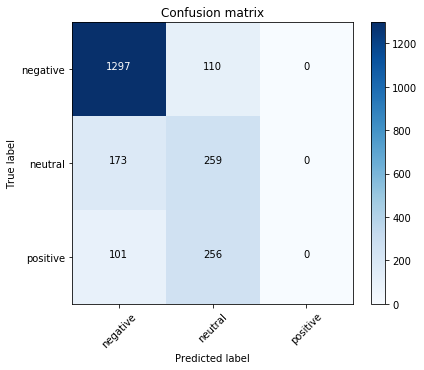

Model Training and Testing time : 0.10979890823364258 secs
Model Testing Accuracy : 0.7085610201449993 
Average precision score: 0.78


[0.6292763640103227, 0.7085610201449993]

In [0]:
# CNN with dropout of 0.2
def base_cnn_dropout_model():
    model = Sequential(
        [
            Embedding(
                input_dim=NB_WORDS,
                output_dim=EMBEDDING_DIM,
                input_length=MAX_LEN),
            Convolution1D(
                filters=64,
                kernel_size=3,
                padding='same',
                activation='relu'),
            MaxPooling1D(),
            Flatten(),
            Dropout(0.2),
            Dense(
                100,
                activation='relu'),
            Dropout(0.2),
            Dense(
                3,
                activation='softmax')])
    model.name = 'BaseCNNWithDropouts'
    model.summary()
    return model

# train and validate
base_cnn_dropout_model = base_cnn_dropout_model()
base_cnn_dropout_history = train_model(
    base_cnn_dropout_model,
    X_train_seq,
    y_train,
    X_valid_seq,
    y_valid)
# train the entire training data and test on test data on base model
test_model(base_cnn_dropout_model, X_test_seq, y_test_one_hot)


### 3.2.3 Experiment 3 - Base CNN with Regularization (L2)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 24, 100)           1000000   
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 24, 64)            19264     
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 12, 64)            0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 768)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 100)               76900     
_________________________________________________________________
dense_8 (Dense)              (None, 3)                 303       
Total params: 1,096,467
Trainable params: 1,096,467
Non-trainable params: 0
_________________________________________________________________


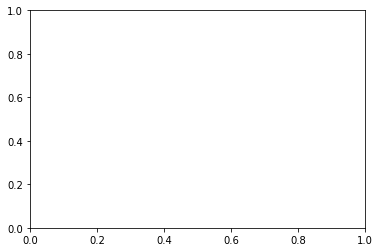

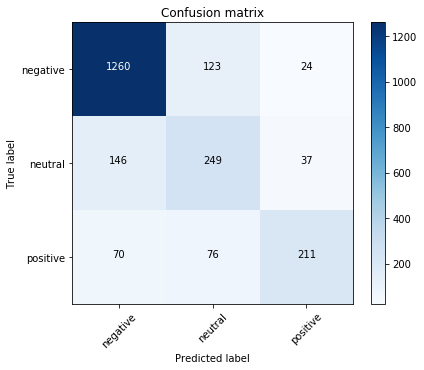

Model Training and Testing time : 0.10879683494567871 secs
Model Testing Accuracy : 0.7832422587606642 
Average precision score: 0.83


[0.6290738218903325, 0.7832422587606642]

In [0]:
# regularization with l2 regularizer
def base_cnn_regularization_model():
    model = Sequential(
        [
            Embedding(
                input_dim=NB_WORDS,
                output_dim=EMBEDDING_DIM,
                input_length=MAX_LEN),
            Convolution1D(
                filters=64,
                kernel_size=3,
                padding='same',
                activation='relu'),
            MaxPooling1D(),
            Flatten(),
            Dense(
                100,
                kernel_regularizer=regularizers.l2(0.001),
                activation='relu'),
            Dense(
                3,
                activation='softmax')])
    model.name = 'BaseCNNWithRegularization'
    model.summary()
    return model


# train and validate
base_cnn_regularization_model = base_cnn_regularization_model()
base_cnn_regularization_history = train_model(
    base_cnn_regularization_model,
    X_train_seq,
    y_train,
    X_valid_seq,
    y_valid)
# test the models
test_model(base_cnn_regularization_model, X_test_seq, y_test_one_hot)


### 3.2.4 Experiment 4 Multi-layer and Multi-filter CNN 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 24, 100)           1000000   
_________________________________________________________________
model_1 (Model)              (None, 64)                57792     
_________________________________________________________________
dense_9 (Dense)              (None, 128)               8320      
_________________________________________________________________
dense_10 (Dense)             (None, 3)                 387       
Total params: 1,066,499
Trainable params: 1,066,499
Non-trainable params: 0
_________________________________________________________________
Train on 10577 samples, validate on 1867 samples
Epoch 1/20
10577/10577 [==============================] - 2s 216us/step - loss: 0.9720 - acc: 0.5901 - val_loss: 0.9127 - val_acc: 0.6133
Epoch 2/20
10577/10577 [==============================] - 2s 206us/step - los

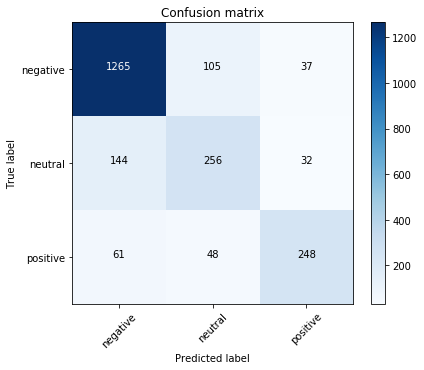

Model Training and Testing time : 0.1772458553314209 secs
Model Testing Accuracy : 0.8055555553384166 
Average precision score: 0.86


[0.5254420709740268, 0.8055555553384166]

In [0]:
def multilayer_multifilter_conv():
    graph_in = Input(shape=(NB_WORDS, 100))

    convs = []
    for filter_size in range(2, 5):
        x = Convolution1D(
            64,
            filter_size,
            padding='same',
            activation='relu')(graph_in)
        convs.append(x)

    graph_out = concatenate(convs, axis=1)
    graph_out = GlobalMaxPooling1D()(graph_out)
    graph = Model(graph_in, graph_out)

    model = Sequential(
        [
            Embedding(
                NB_WORDS, output_dim=EMBEDDING_DIM, input_length=MAX_LEN), graph, Dense(
                128, activation='relu'), Dense(
                    3, activation='softmax')])
    model.name = 'MultiLayerMultiFilterCNN'
    model.summary()
    return model


#train and validate
multi_filter_conv_model = multilayer_multifilter_conv()
multi_filter_conv_history = train_model(
    multi_filter_conv_model,
    X_train_seq,
    y_train,
    X_valid_seq,
    y_valid)

# test the models
test_model(multi_filter_conv_model, X_test_seq, y_test_one_hot)


### 3.2.5 Experiment 5 Multi-layer, Increased Number of Filters and Multi-filter CNN 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 24, 100)           1000000   
_________________________________________________________________
model_2 (Model)              (None, 128)               115584    
_________________________________________________________________
dense_11 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_12 (Dense)             (None, 3)                 387       
Total params: 1,132,483
Trainable params: 1,132,483
Non-trainable params: 0
_________________________________________________________________
Train on 10577 samples, validate on 1867 samples
Epoch 1/20
10577/10577 [==============================] - 4s 338us/step - loss: 0.9282 - acc: 0.6200 - val_loss: 0.8808 - val_acc: 0.6133
Epoch 2/20
10577/10577 [==============================] - 3s 318us/step - los

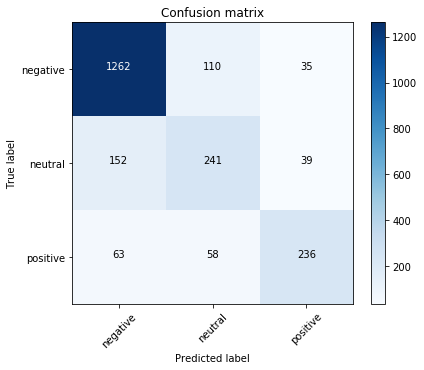

Model Training and Testing time : 0.21707510948181152 secs
Model Testing Accuracy : 0.7918943534783327 
Average precision score: 0.85


[0.5281359052831792, 0.7918943534783327]

In [0]:
def multilayer_multifilter_increased_size_conv():
    graph_in = Input(shape=(NB_WORDS, 100))

    convs = []
    for filter_size in range(2, 5):
        x = Convolution1D(
            128,
            filter_size,
            padding='same',
            activation='relu')(graph_in)
        convs.append(x)

    graph_out = concatenate(convs, axis=1)
    graph_out = GlobalMaxPooling1D()(graph_out)
    graph = Model(graph_in, graph_out)

    model = Sequential(
        [
            Embedding(
                NB_WORDS, output_dim=EMBEDDING_DIM, input_length=MAX_LEN), graph, Dense(
                128, activation='relu'), Dense(
                    3, activation='softmax')])
    model.name = 'MultiLayerMultiFilterIncreasedSizeCNN'
    model.summary()
    return model


# train and validate
multilayer_multifilter_increased_size_model = multilayer_multifilter_increased_size_conv()
multilayer_multifilter_increased_size_history = train_model(
    multilayer_multifilter_increased_size_model,
    X_train_seq,
    y_train,
    X_valid_seq,
    y_valid)

# test the models
test_model(
    multilayer_multifilter_increased_size_model,
    X_test_seq,
    y_test_one_hot)


## Embedding File load in the memory 

In [11]:
embeddings = read_embedding(GLOVE_EMBEDDINGS_FILE)

### 3.2.6 Experiment 6 Multi-layer, Multi-filter, Static Pretrained Embeddings

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_13 (Embedding)     (None, 24, 100)           1000100   
_________________________________________________________________
model_8 (Model)              (None, 64)                57792     
_________________________________________________________________
dense_24 (Dense)             (None, 128)               8320      
_________________________________________________________________
dense_25 (Dense)             (None, 3)                 387       
Total params: 1,066,599
Trainable params: 66,499
Non-trainable params: 1,000,100
_________________________________________________________________
Train on 10577 samples, validate on 1867 samples
Epoch 1/20
10577/10577 [==============================] - 2s 191us/step - loss: 0.8128 - acc: 0.6622 - val_loss: 0.7520 - val_acc: 0.6840
Epoch 2/20
10577/10577 [==============================] - 2s 166us/step 

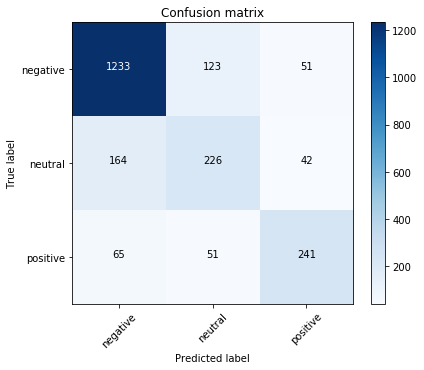

Model Training and Testing time : 0.18318700790405273 secs
Model Testing Accuracy : 0.7741347907453721 
Average precision score: 0.84


[0.5462333824899461, 0.7741347907453721]

In [0]:
# create embedding matrix for the experiment
emb_matrix = create_embedding_matrix(tk, 100, embeddings)


def multilayer_multifilter_glove_cnn():
    graph_in = Input(shape=(NB_WORDS + 1, 100))

    convs = []
    for filter_size in range(2, 5):
        x = Convolution1D(
            64,
            filter_size,
            padding='same',
            activation='relu')(graph_in)
        convs.append(x)

    graph_out = concatenate(convs, axis=1)
    graph_out = GlobalMaxPooling1D()(graph_out)
    graph = Model(graph_in, graph_out)

    model = Sequential([Embedding(NB_WORDS + 1,
                                  EMBEDDING_DIM,
                                  weights=[emb_matrix],
                                  trainable=False,
                                  input_length=MAX_LEN),
                        graph,
                        Dense(128,
                              activation='relu'),
                        Dense(3,
                              activation='softmax')])
    model.name = 'MultiLayerMultiFilterStaticEmbeddingsCNN'
    model.summary()
    return model


# train and validate
multilayer_multifilter_glove_model = multilayer_multifilter_glove_cnn()
multilayer_multifilter_glove_history = train_model(
    multilayer_multifilter_glove_model, X_train_seq, y_train, X_valid_seq, y_valid)
# test the models
test_model(multilayer_multifilter_glove_model, X_test_seq, y_test_one_hot)


### 3.2.7 Experiment  Multi-layer, Multi-filter, Dynamic Pretrained Embeddings

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_14 (Embedding)     (None, 24, 100)           1000100   
_________________________________________________________________
model_9 (Model)              (None, 64)                57792     
_________________________________________________________________
dense_26 (Dense)             (None, 128)               8320      
_________________________________________________________________
dense_27 (Dense)             (None, 3)                 387       
Total params: 1,066,599
Trainable params: 1,066,599
Non-trainable params: 0
_________________________________________________________________
Train on 10577 samples, validate on 1867 samples
Epoch 1/20
10577/10577 [==============================] - 3s 243us/step - loss: 0.8343 - acc: 0.6509 - val_loss: 0.7539 - val_acc: 0.6786
Epoch 2/20
10577/10577 [==============================] - 2s 206us/step - los

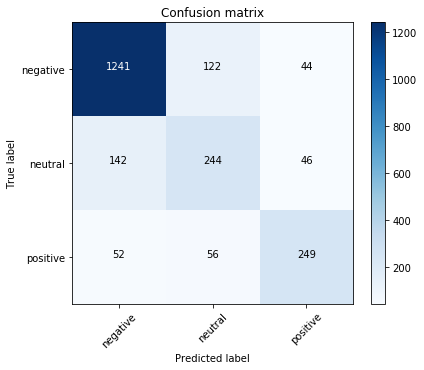

Model Training and Testing time : 0.19419384002685547 secs
Model Testing Accuracy : 0.7896174863387978 
Average precision score: 0.85


[0.5199250678764232, 0.7896174863387978]

In [0]:
# create embedding matrix for the experiment
emb_matrix = create_embedding_matrix(tk, 100, embeddings)


def multilayer_multifilter_glove_dynamic_cnn():
    graph_in = Input(shape=(NB_WORDS + 1, 100))

    convs = []
    for filter_size in range(2, 5):
        x = Convolution1D(
            64,
            filter_size,
            padding='same',
            activation='relu')(graph_in)
        convs.append(x)

    graph_out = concatenate(convs, axis=1)
    graph_out = GlobalMaxPooling1D()(graph_out)
    graph = Model(graph_in, graph_out)

    model = Sequential([Embedding(NB_WORDS + 1,
                                  EMBEDDING_DIM,
                                  weights=[emb_matrix],
                                  trainable=True,
                                  input_length=MAX_LEN),
                        graph,
                        Dense(128,
                              activation='relu'),
                        Dense(3,
                              activation='softmax')])
    model.name = 'MultiLayerMultiFilterDynamicEmbeddingsCNN'
    model.summary()
    return model


# train and validate
multilayer_multifilter_glove_dynamic_model = multilayer_multifilter_glove_dynamic_cnn()
multilayer_multifilter_glove_dynamic_history = train_model(
    multilayer_multifilter_glove_dynamic_model,
    X_train_seq,
    y_train,
    X_valid_seq,
    y_valid)

# test the models
test_model(
    multilayer_multifilter_glove_dynamic_model,
    X_test_seq,
    y_test_one_hot)


### 3.2.8 Experiment 8 Yoon Kim's Model Single Channel

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 24)           0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 24, 100)      1000100     input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 24, 128)      38528       embedding_1[0][0]                
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 24, 128)      51328       embedding_1[0][0]                
__________________________________________________________________________________________________
conv1d_3 (

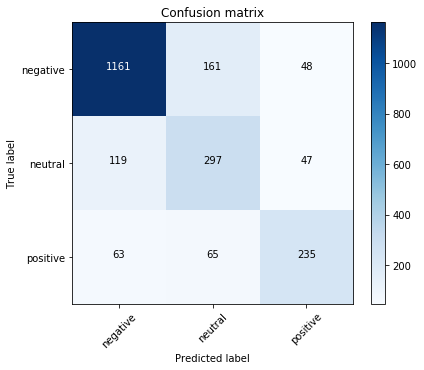

Model Training and Testing time : 0.27002501487731934 secs
Model Testing Accuracy : 0.7709471766848816 
Average precision score: 0.84


[0.5584423646249407, 0.7709471766848816]

In [12]:
# create embedding matrix for the experiment
emb_matrix = create_embedding_matrix(tk, 100, embeddings)


def single_channel_kim_cnn():
    text_seq_input = Input(shape=(MAX_LEN,), dtype='int32')
    text_embedding = Embedding(NB_WORDS + 1,
                               EMBEDDING_DIM,
                               weights=[emb_matrix],
                               trainable=True,
                               input_length=MAX_LEN)(text_seq_input)

    filter_sizes = [3, 4, 5]
    convs = []
    for filter_size in filter_sizes:
        l_conv = Convolution1D(
            filters=128,
            kernel_size=filter_size,
            padding='same',
            activation='relu')(text_embedding)
        l_pool = MaxPooling1D(filter_size)(l_conv)
        convs.append(l_pool)

    merge = concatenate(convs, axis=1)
    convol = Convolution1D(128, 5, activation='relu')(merge)
    pool1 = GlobalMaxPooling1D()(convol)
    dense = Dense(128, activation='relu', name='Dense')(pool1)
    out = Dense(3, activation='softmax')(dense)
    model = Model(
        inputs=[text_seq_input],
        outputs=out,
        name="KimSingleChannelCNN")
    model.summary()
    return model


single_channel_kim_model = single_channel_kim_cnn()
single_channel_kim_model_history = train_model(
    single_channel_kim_model, X_train_seq, y_train, X_valid_seq, y_valid)
# test the models
test_model(single_channel_kim_model, X_test_seq, y_test_one_hot)


## 3.2.9 Experiment 9 Yoon Kim's Model Multiple Channel


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_15 (InputLayer)           (None, 24)           0                                            
__________________________________________________________________________________________________
embedding_18 (Embedding)        (None, 24, 100)      1000100     input_15[0][0]                   
__________________________________________________________________________________________________
embedding_19 (Embedding)        (None, 24, 100)      1000100     input_15[0][0]                   
__________________________________________________________________________________________________
conv1d_39 (Conv1D)              (None, 24, 128)      38528       embedding_18[0][0]               
__________________________________________________________________________________________________
conv1d_40 

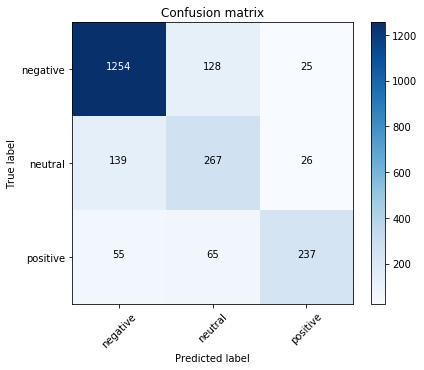

Model Training and Testing time : 0.6000800132751465 secs
Model Testing Accuracy : 0.8005464480874317 
Average precision score: 0.86


[0.5097816736320329, 0.8005464480874317]

In [0]:
# create embedding matrix for the experiment
emb_matrix1 = create_embedding_matrix(tk, 100, embeddings)
emb_matrix2 = create_embedding_matrix(tk, 100, embeddings)
# a static and a dynamic channel


def multiple_channel_kim_cnn():
    text_seq_input = Input(shape=(MAX_LEN,), dtype='int32')
    text_embedding1 = Embedding(
        NB_WORDS + 1,
        EMBEDDING_DIM,
        weights=[emb_matrix1],
        input_length=MAX_LEN,
        trainable=True)(text_seq_input)
    text_embedding2 = Embedding(
        NB_WORDS + 1,
        EMBEDDING_DIM,
        weights=[emb_matrix2],
        input_length=MAX_LEN,
        trainable=False)(text_seq_input)
    filter_sizes = [3, 4, 5]
    convs = []
    for text_embedding in [text_embedding1, text_embedding2]:
        for filter_size in filter_sizes:
            l_conv = Convolution1D(
                filters=128,
                kernel_size=filter_size,
                padding='same',
                activation='relu')(text_embedding)
            l_pool = MaxPooling1D(filter_size)(l_conv)
            convs.append(l_pool)
    merge = concatenate(convs, axis=1)
    convol = Convolution1D(128, 5, activation='relu')(merge)
    pool1 = GlobalMaxPooling1D()(convol)
    dense = Dense(128, activation='relu', name='last_but_one')(pool1)
    out = Dense(3, activation='softmax')(dense)
    model = Model(
        inputs=[text_seq_input],
        outputs=out,
        name="KimMultipleChannelCNN")
    model.summary()
    return model


multiple_channel_kim_model = multiple_channel_kim_cnn()
multiple_channel_kim_history = train_model(
    multiple_channel_kim_model,
    X_train_seq,
    y_train,
    X_valid_seq,
    y_valid)
# test the models
test_model(multiple_channel_kim_model, X_test_seq, y_test_one_hot)


## 3.2.10 Experiment 10 Kalchbrenner et al Dynamic CNN

In [0]:
# This code is adapted from arbackus's suggestion in Keras

from keras.engine import Layer, InputSpec
import tensorflow as tf


class KMaxPooling(Layer):
    """
    K-max pooling layer that extracts the k-highest activations from a sequence (2nd dimension).
    TensorFlow backend.
    """

    def __init__(self, k=1, axis=1, **kwargs):
        super(KMaxPooling, self).__init__(**kwargs)
        self.input_spec = InputSpec(ndim=3)
        self.k = k

        assert axis in [
            1, 2], 'expected dimensions (samples, filters, convolved_values),\
                   cannot fold along samples dimension or axis not in list [1,2]'
        self.axis = axis

        # need to switch the axis with the last elemnet
        # to perform transpose for tok k elements since top_k works in last
        # axis
        self.transpose_perm = [0, 1, 2]  # default
        self.transpose_perm[self.axis] = 2
        self.transpose_perm[2] = self.axis

    def compute_output_shape(self, input_shape):
        input_shape_list = list(input_shape)
        input_shape_list[self.axis] = self.k
        return tuple(input_shape_list)

    def call(self, x):
        # swap sequence dimension to get top k elements along axis=1
        transposed_for_topk = tf.transpose(x, perm=self.transpose_perm)

        # extract top_k, returns two tensors [values, indices]
        top_k = tf.nn.top_k(
            transposed_for_topk,
            k=self.k,
            sorted=True,
            name=None)[0]

        # return back to normal dimension but now sequence dimension has only k elements
        # performing another transpose will get the tensor back to its original shape
        # but will have k as its axis_1 size
        transposed_back = tf.transpose(top_k, perm=self.transpose_perm)

        return transposed_back


class Folding(Layer):

    def __init__(self, **kwargs):
        super(Folding, self).__init__(**kwargs)
        self.input_spec = InputSpec(ndim=3)

    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[1], int(input_shape[2] / 2))

    def call(self, x):
        input_shape = x.get_shape().as_list()

        # split the tensor along dimension 2 into dimension_axis_size/2
        # which will give us 2 tensors
        splits = tf.split(
            x, num_or_size_splits=int(
                input_shape[2] / 2), axis=2)

        # reduce sums of the pair of rows we have split onto
        reduce_sums = [tf.reduce_sum(split, axis=2) for split in splits]

        # stack them up along the same axis we have reduced
        row_reduced = tf.stack(reduce_sums, axis=2)
        return row_reduced


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_21 (Embedding)     (None, 24, 100)           1000100   
_________________________________________________________________
zero_padding1d_2 (ZeroPaddin (None, 122, 100)          0         
_________________________________________________________________
conv1d_47 (Conv1D)           (None, 122, 64)           320064    
_________________________________________________________________
k_max_pooling_1 (KMaxPooling (None, 5, 64)             0         
_________________________________________________________________
activation_1 (Activation)    (None, 5, 64)             0         
_________________________________________________________________
zero_padding1d_3 (ZeroPaddin (None, 53, 64)            0         
_________________________________________________________________
conv1d_48 (Conv1D)           (None, 53, 64)            102464    
__________

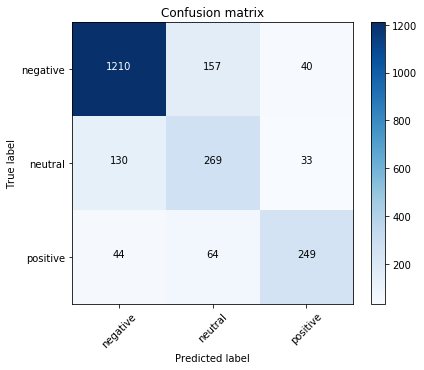

Model Training and Testing time : 2.743029832839966 secs
Model Testing Accuracy : 0.7868852459016393 
Average precision score: 0.85


[0.519886214550727, 0.7868852459016393]

In [0]:
trained_embeddings = create_embedding_matrix(tk, 100, embeddings)


def dynamic_cnn():
    model = Sequential(
        [
            Embedding(
                NB_WORDS + 1,
                EMBEDDING_DIM,
                weights=[trained_embeddings],
                input_length=MAX_LEN,
                trainable=True),
            ZeroPadding1D(
                (49,
                 49)),
            Convolution1D(
                64,
                50,
                padding="same"),
            KMaxPooling(
                k=5,
                axis=1),
            Activation("relu"),
            ZeroPadding1D(
                (24,
                 24)),
            Convolution1D(
                64,
                25,
                padding="same"),
            Folding(),
            KMaxPooling(
                k=5,
                axis=1),
            Activation("relu"),
            Flatten(),
            Dense(
                3,
                activation="softmax")])
    model.name = 'KalchbrennerDynamicCNN'
    model.summary()
    return model


dynamic_cnn_model = dynamic_cnn()
dynamic_cnn_history = train_model(
    dynamic_cnn_model,
    X_train_seq,
    y_train,
    X_valid_seq,
    y_valid)
# test the models
test_model(dynamic_cnn_model, X_test_seq, y_test_one_hot)


## 3.2.11 Experiment 11 Multi Channel Variable size CNN

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_16 (InputLayer)           (None, 24)           0                                            
__________________________________________________________________________________________________
embedding_22 (Embedding)        (None, 24, 100)      1000100     input_16[0][0]                   
__________________________________________________________________________________________________
embedding_23 (Embedding)        (None, 24, 100)      1000100     input_16[0][0]                   
__________________________________________________________________________________________________
zero_padding1d_4 (ZeroPadding1D (None, 28, 100)      0           embedding_22[0][0]               
__________________________________________________________________________________________________
zero_paddi

Train on 10577 samples, validate on 1867 samples
Epoch 1/20
10577/10577 [==============================] - 28s 3ms/step - loss: 1.1450 - acc: 0.5894 - val_loss: 0.8176 - val_acc: 0.6524
Epoch 2/20
10577/10577 [==============================] - 32s 3ms/step - loss: 0.7371 - acc: 0.6953 - val_loss: 0.6897 - val_acc: 0.7252
Epoch 3/20
10577/10577 [==============================] - 30s 3ms/step - loss: 0.6112 - acc: 0.7597 - val_loss: 0.6097 - val_acc: 0.7574
Epoch 4/20
10577/10577 [==============================] - 31s 3ms/step - loss: 0.5306 - acc: 0.7904 - val_loss: 0.5853 - val_acc: 0.7649
Epoch 5/20
10577/10577 [==============================] - 31s 3ms/step - loss: 0.4618 - acc: 0.8195 - val_loss: 0.5484 - val_acc: 0.7809
Epoch 6/20
10577/10577 [==============================] - 30s 3ms/step - loss: 0.3905 - acc: 0.8507 - val_loss: 0.5596 - val_acc: 0.7847
Epoch 7/20
10577/10577 [==============================] - 31s 3ms/step - loss: 0.3287 - acc: 0.8767 - val_loss: 0.5687 - val_acc:

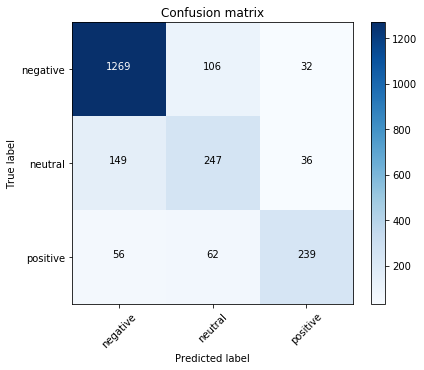

Model Training and Testing time : 2.5095551013946533 secs
Model Testing Accuracy : 0.7991803278688525 
Average precision score: 0.85


[0.5024506696152122, 0.7991803278688525]

In [0]:
trained_embeddings1 = create_embedding_matrix(tk, 100, embeddings)
trained_embeddings2 = create_embedding_matrix(tk, 100, embeddings)

# two channels with static and dynamic


def multichannel_variable_cnn():
    text_seq_input = Input(shape=(MAX_LEN,), dtype='int32')
    text_embedding1 = Embedding(
        NB_WORDS + 1,
        EMBEDDING_DIM,
        weights=[trained_embeddings1],
        input_length=MAX_LEN,
        trainable=True)(text_seq_input)
    text_embedding2 = Embedding(
        NB_WORDS + 1,
        EMBEDDING_DIM,
        weights=[trained_embeddings2],
        input_length=MAX_LEN,
        trainable=False)(text_seq_input)

    k_top = 4

    layer_1 = []
    for text_embedding in [text_embedding1, text_embedding2]:
        conv_pools = []
        filter_sizes = [3, 5]
        for filter_size in filter_sizes:
            l_zero = ZeroPadding1D(
                (filter_size - 1, filter_size - 1))(text_embedding)
            l_conv = Convolution1D(
                filters=128,
                kernel_size=filter_size,
                padding='same',
                activation='tanh')(l_zero)
            l_pool = KMaxPooling(k=28, axis=1)(l_conv)
            conv_pools.append((filter_size, l_pool))
            layer_1.append(conv_pools)

    last_layer = []
    for layer in layer_1:  # no of embeddings used
        for (filter_size, input_feature_maps) in layer:
            l_zero = ZeroPadding1D(
                (filter_size - 1, filter_size - 1))(input_feature_maps)
            l_conv = Convolution1D(
                filters=128,
                kernel_size=filter_size,
                padding='same',
                activation='tanh')(l_zero)
            l_pool = KMaxPooling(k=k_top, axis=1)(l_conv)
            last_layer.append(l_pool)

    l_merge = concatenate(last_layer, axis=1)
    l_flat = Flatten()(l_merge)
    l_dense = Dense(128, activation='relu')(l_flat)
    l_out = Dense(3, activation='softmax')(l_dense)
    model = Model(inputs=[text_seq_input], outputs=l_out)
    model.name = 'MultiChannelVariableCNN'
    model.summary()
    return model


multichannel_variable_cnn_model = multichannel_variable_cnn()
multichannel_variable_cnn_history = train_model(
    multichannel_variable_cnn_model,
    X_train_seq,
    y_train,
    X_valid_seq,
    y_valid)
# test the models
test_model(multichannel_variable_cnn_model, X_test_seq, y_test_one_hot)


## 3.2.12 Experiment 12 Multi Group  CNN

In [0]:
# laod the embedding file
fasttext_embeddings = read_embedding(FASTTEXT_EMBEDDINGS_FILE)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_17 (InputLayer)           (None, 24)           0                                            
__________________________________________________________________________________________________
embedding_24 (Embedding)        (None, 24, 100)      1000100     input_17[0][0]                   
__________________________________________________________________________________________________
embedding_25 (Embedding)        (None, 24, 100)      1000100     input_17[0][0]                   
__________________________________________________________________________________________________
embedding_26 (Embedding)        (None, 24, 300)      3000300     input_17[0][0]                   
__________________________________________________________________________________________________
zero_paddi

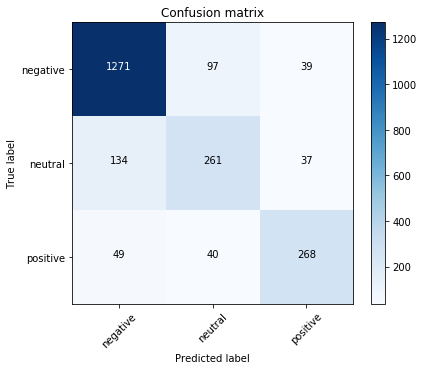

Model Training and Testing time : 0.4357130527496338 secs
Model Testing Accuracy : 0.819672131147541 
Average precision score: 0.87


[0.5482111540648456, 0.819672131147541]

In [0]:
# 100-d GloVe embeddings
trained_embeddings1 = create_embedding_matrix(tk, EMBEDDING_DIM, embeddings)
# 100-d GloVe embeddings
trained_embeddings2 = create_embedding_matrix(tk, EMBEDDING_DIM, embeddings)
# 300-d fastText embeddings
trained_embeddings3 = create_embedding_matrix(
    tk, FASTTEXT_EMBEDDING_DIM, fasttext_embeddings)


def multigroup_normconstraint_cnn():
    text_seq_input = Input(shape=(MAX_LEN,), dtype='int32')
    text_embedding1 = Embedding(
        NB_WORDS + 1,
        EMBEDDING_DIM,
        weights=[trained_embeddings1],
        input_length=MAX_LEN,
        trainable=True)(text_seq_input)
    text_embedding2 = Embedding(
        NB_WORDS + 1,
        EMBEDDING_DIM,
        weights=[trained_embeddings2],
        input_length=MAX_LEN,
        trainable=False)(text_seq_input)
    text_embedding3 = Embedding(
        NB_WORDS + 1,
        FASTTEXT_EMBEDDING_DIM,
        weights=[trained_embeddings3],
        input_length=MAX_LEN,
        trainable=True)(text_seq_input)

    k_top = 4
    filter_sizes = [3, 5]

    conv_pools = []
    for text_embedding in [text_embedding1, text_embedding2, text_embedding3]:
        for filter_size in filter_sizes:
            l_zero = ZeroPadding1D(
                (filter_size - 1, filter_size - 1))(text_embedding)
            l_conv = Convolution1D(
                filters=16,
                kernel_size=filter_size,
                padding='same',
                activation='tanh')(l_zero)
            l_pool = GlobalMaxPooling1D()(l_conv)
            conv_pools.append(l_pool)

    l_merge = concatenate(conv_pools, axis=1)
    l_dense = Dense(
        128,
        activation='relu',
        kernel_regularizer=regularizers.l2(0.001))(l_merge)
    l_out = Dense(3, activation='softmax')(l_dense)
    model = Model(inputs=[text_seq_input], outputs=l_out)
    model.name = 'MultiGroupNormConstraintCNN'
    model.summary()
    return model


multigroup_normconstraint_cnn_model = multigroup_normconstraint_cnn()
multigroup_normconstraint_cnn_history = train_model(
    multigroup_normconstraint_cnn_model,
    X_train_seq,
    y_train,
    X_valid_seq,
    y_valid)
# test the models
test_model(multigroup_normconstraint_cnn_model, X_test_seq, y_test_one_hot)


## Character-based tokenziation of Train and Test

In [0]:
print('Current Sequences are :', X_train_entire.shape)
tokenizer = Tokenizer(char_level=True)
tokenizer.fit_on_texts(list(X_train_entire))


# train data
list_tokenized_train = tokenizer.texts_to_sequences(X_train_entire)
X_train_entire_char = pad_sequences(list_tokenized_train, maxlen=MAX_SENT_LEN)
# test data
list_tokenized_test = tokenizer.texts_to_sequences(X_test)
X_test_char = pad_sequences(list_tokenized_test, maxlen=MAX_SENT_LEN)

X_train_char, X_valid_char, y_train_char, y_valid_char = train_test_split(
    X_train_entire_char, y_train_one_hot, test_size=0.15, random_state=37)

assert X_valid_char.shape[0] == y_valid_char.shape[0]
assert X_train_char.shape[0] == y_train_char.shape[0]

print('Shape of Training set:', X_train_char.shape)
print('Shape of validation set:', X_valid_char.shape)

Current Sequences are : (12444,)
Shape of Training set: (10577, 300)
Shape of validation set: (1867, 300)


## 3.13 Experiment 13 Character-based CNN

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_18 (InputLayer)           (None, None)         0                                            
__________________________________________________________________________________________________
embedding_27 (Embedding)        (None, 300, 128)     131072      input_18[0][0]                   
__________________________________________________________________________________________________
conv1d_67 (Conv1D)              (None, 291, 256)     327936      embedding_27[0][0]               
__________________________________________________________________________________________________
conv1d_68 (Conv1D)              (None, 294, 256)     229632      embedding_27[0][0]               
__________________________________________________________________________________________________
conv1d_69 

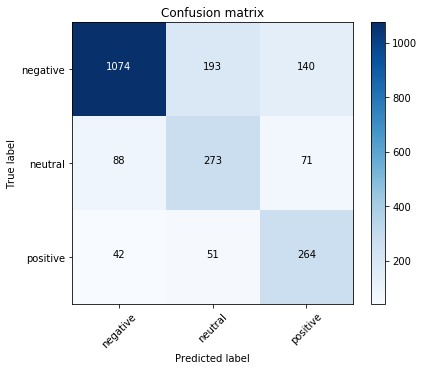

Model Training and Testing time : 8.907570838928223 secs
Model Testing Accuracy : 0.7336065573770492 
Average precision score: 0.82


[0.8038452763809315, 0.7336065573770492]

In [0]:
char_embeddings = np.random.randn(1024, 128)
char_embeddings.shape


def character_multiplefilter_cnn():
       # Input layer
    inputs = Input(shape=(None, ))
    x = Embedding(1024, 128, weights=[char_embeddings],
                  input_length=300, trainable=True)(inputs)
    filter_sizes = [10, 7, 5, 3]
    convs = []
    for filter_size in filter_sizes:
        l_conv = Convolution1D(
            filters=256,
            kernel_size=filter_size,
            activation='tanh')(x)
        l_pool = GlobalMaxPooling1D()(l_conv)
        convs.append(l_pool)
    x = concatenate(convs, axis=1)
    # Fully connected layers
    x = Dense(1024, activation='selu', kernel_initializer='lecun_normal')(x)
    x = AlphaDropout(0.5)(x)
    x = Dense(1024, activation='selu', kernel_initializer='lecun_normal')(x)
    x = Dropout(0.5)(x)
    # output layer
    predictions = Dense(3, activation='softmax')(x)
    # Build and compile model
    model = Model(inputs=inputs, outputs=predictions)
    model.name = 'CharacterBasedMultipleFilterCNN'
    model.summary()
    return model


character_multiplefilter_cnn_model = character_multiplefilter_cnn()
character_multiplefilter_cnn_history = train_model(
    character_multiplefilter_cnn_model,
    X_train_char,
    y_train_char,
    X_valid_char,
    y_valid_char)

# test the models
test_model(character_multiplefilter_cnn_model, X_test_char, y_test_one_hot)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_19 (InputLayer)        (None, None)              0         
_________________________________________________________________
embedding_28 (Embedding)     (None, 300, 64)           65536     
_________________________________________________________________
conv1d_71 (Conv1D)           (None, 294, 256)          114944    
_________________________________________________________________
thresholded_re_lu_1 (Thresho (None, 294, 256)          0         
_________________________________________________________________
max_pooling1d_17 (MaxPooling (None, 98, 256)           0         
_________________________________________________________________
conv1d_72 (Conv1D)           (None, 92, 256)           459008    
_________________________________________________________________
thresholded_re_lu_2 (Thresho (None, 92, 256)           0         
__________

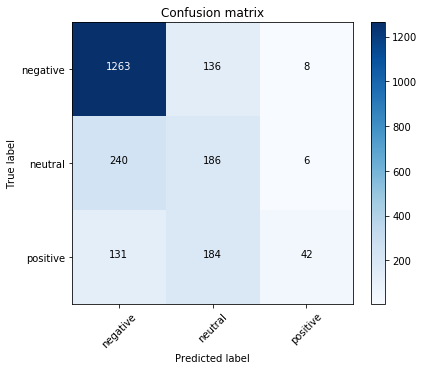

Model Training and Testing time : 4.758619785308838 secs
Model Testing Accuracy : 0.6789617485253103 
Average precision score: 0.73


[0.7261184256367779, 0.6789617485253103]

In [0]:
char_embeddings = np.random.randn(1024, 64)


def character_zhang_cnn():
    # Input layer
    inputs = Input(shape=(None, ))
    x = Embedding(1024, 64, weights=[char_embeddings],
                  input_length=300, trainable=True)(inputs)
    # convolution layers
    # layer 1
    x = Convolution1D(256, 7)(x)
    x = ThresholdedReLU(1e-6)(x)
    x = MaxPooling1D(3)(x)
    # layer 2
    x = Convolution1D(256, 7)(x)
    x = ThresholdedReLU(1e-6)(x)
    x = MaxPooling1D(3)(x)
    # layer 3
    x = Convolution1D(256, 7)(x)
    x = ThresholdedReLU(1e-6)(x)
    # layer 4
    x = Convolution1D(256, 7)(x)
    x = ThresholdedReLU(1e-6)(x)
    # layer 5
    x = Convolution1D(256, 7)(x)
    x = ThresholdedReLU(1e-6)(x)
    # layer 6
    x = Convolution1D(256, 3)(x)
    # layer 7
    x = ThresholdedReLU(1e-6)(x)
    x = MaxPooling1D(3)(x)
    # Flatten
    x = Flatten()(x)
    # Fully connected layers
    x = Dense(1024)(x)
    x = ThresholdedReLU(1e-6)(x)
    x = Dropout(0.5)(x)
    x = Dense(1024)(x)
    x = ThresholdedReLU(1e-6)(x)
    x = Dropout(0.5)(x)
    # Output layer
    predictions = Dense(3, activation='softmax')(x)
    # Build and compile model
    model = Model(inputs=inputs, outputs=predictions)
    model.name = 'CharacterBasedZhangCNN'
    model.summary()
    return model


character_zhang_cnn_model = character_zhang_cnn()
character_zhang_cnn_history = train_model(
    character_zhang_cnn_model,
    X_train_char,
    y_train_char,
    X_valid_char,
    y_valid_char)
# test the models
test_model(character_zhang_cnn_model, X_test_char, y_test_one_hot)


## 3.2.14  Experiment 14 Very Deep Convolutional Networks for Text Classification

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_41 (Embedding)     (None, 300, 64)           19200     
_________________________________________________________________
conv1d_133 (Conv1D)          (None, 298, 64)           12352     
_________________________________________________________________
conv1d_134 (Conv1D)          (None, 298, 64)           12352     
_________________________________________________________________
batch_normalization_1 (Batch (None, 298, 64)           256       
_________________________________________________________________
activation_23 (Activation)   (None, 298, 64)           0         
_________________________________________________________________
conv1d_135 (Conv1D)          (None, 298, 64)           12352     
_________________________________________________________________
batch_normalization_2 (Batch (None, 298, 64)           256       
__________

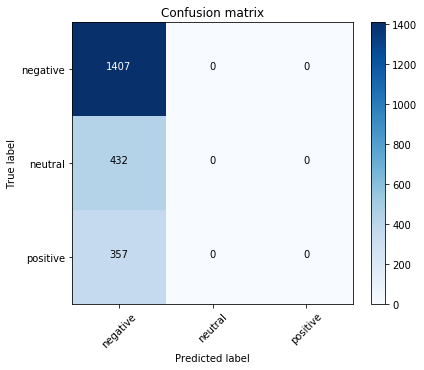

Model Training and Testing time : 6.616180896759033 secs
Model Testing Accuracy : 0.6407103822965222 
Average precision score: 0.48


[5.7910643075550405, 0.6407103822965222]

In [0]:
char_embeddings = np.random.randn(300, 64)
char_embeddings.shape


def very_deep_character_cnn():
    model = Sequential([
        Embedding(300, 64, weights=[char_embeddings],
                  input_length=300, trainable=True),
        Convolution1D(64, 3, padding="valid")
    ])

    # 4 pairs of convolution blocks followed by pooling
    for filter_size in [64, 128, 256]:

        # each iteration is a convolution block
        for cb_i in [0, 1]:
            model.add(Convolution1D(filter_size, 3, padding="same"))
            model.add(BatchNormalization())
            model.add(Activation("relu"))
            model.add(Convolution1D(filter_size, 3, padding="same")),
            model.add(BatchNormalization())
            model.add(Activation("relu"))

        model.add(MaxPooling1D(pool_size=2, strides=3))

    # model.add(KMaxPooling(k=2))
    model.add(Flatten())
    model.add(Dense(4096, activation="relu"))
    model.add(Dense(2048, activation="relu"))
    model.add(Dense(2048, activation="relu"))
    model.add(Dense(3, activation="softmax"))
    model.name = "VeryDeepCharacterBasedCNN"
    model.summary()
    return model


very_deep_character_cnn_model = very_deep_character_cnn()
very_deep_character_cnn_history = train_model(
    very_deep_character_cnn_model,
    X_train_char,
    y_train_char,
    X_valid_char,
    y_valid_char)
# test the models
test_model(very_deep_character_cnn_model, X_test_char, y_test_one_hot)


## 3.2.15 Experiment 15 CNN with Dilations

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_21 (InputLayer)           (None, None)         0                                            
__________________________________________________________________________________________________
embedding_30 (Embedding)        (None, None, 256)    47360       input_21[0][0]                   
__________________________________________________________________________________________________
dropout_12 (Dropout)            (None, None, 256)    0           embedding_30[0][0]               
__________________________________________________________________________________________________
word_fcl_0 (Conv1D)             (None, None, 16)     4112        dropout_12[0][0]                 
__________________________________________________________________________________________________
ngram_2_cn

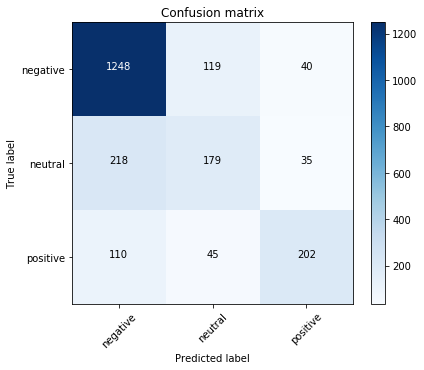

Model Training and Testing time : 1.5168960094451904 secs
Model Testing Accuracy : 0.7418032787970941 
Average precision score: 0.78


[0.6330444519637061, 0.7418032787970941]

In [0]:


def character_dilated_cnn(conv_layers=2,
                          dilation_rates=[0, 2, 4],
                          embed_size=256):
    inp = Input(shape=(None, ))
    x = Embedding(input_dim=len(tokenizer.word_counts) + 1,
                  output_dim=embed_size)(inp)
    prefilt_x = Dropout(0.25)(x)
    out_conv = []
    # dilation rate lets us use ngrams and skip grams to process
    for dilation_rate in dilation_rates:
        x = prefilt_x
        for i in range(2):
            if dilation_rate > 0:
                x = Convolution1D(
                    16 * 2**(i),
                    kernel_size=3,
                    dilation_rate=dilation_rate,
                    activation='relu',
                    name='ngram_{}_cnn_{}'.format(
                        dilation_rate,
                        i))(x)
            else:
                x = Convolution1D(16 * 2**(i),
                                  kernel_size=1,
                                  activation='relu',
                                  name='word_fcl_{}'.format(i))(x)
        out_conv += [Dropout(0.5)(GlobalMaxPooling1D()(x))]
    x = concatenate(out_conv, axis=-1)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.1)(x)
    x = Dense(32, activation='relu')(x)
    x = Dropout(0.1)(x)
    x = Dense(3, activation='sigmoid')(x)
    model = Model(inputs=inp, outputs=x)
    model.name = 'CharacterDilationCNN'
    model.summary()
    return model


character_dilated_cnn_model = character_dilated_cnn()
character_dilated_cnn_history = train_model(
    character_dilated_cnn_model,
    X_train_char,
    y_train_char,
    X_valid_char,
    y_valid_char)
# test the models
test_model(character_dilated_cnn_model, X_test_char, y_test_one_hot)


## 3.2.16 Experiment 16 Ensemble of CNN and LSTM

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_22 (InputLayer)           (None, 24)           0                                            
__________________________________________________________________________________________________
embedding_31 (Embedding)        (None, 24, 100)      1000100     input_22[0][0]                   
__________________________________________________________________________________________________
conv1d_77 (Conv1D)              (None, 24, 128)      38528       embedding_31[0][0]               
__________________________________________________________________________________________________
conv1d_78 (Conv1D)              (None, 24, 128)      51328       embedding_31[0][0]               
__________________________________________________________________________________________________
conv1d_79 

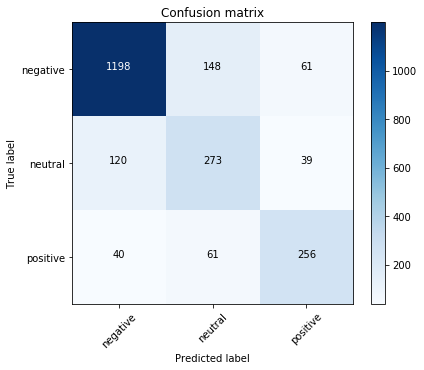

Model Training and Testing time : 0.8616430759429932 secs
Model Testing Accuracy : 0.7864298723868768 
Average precision score: 0.84


[0.5327857271352535, 0.7864298723868768]

In [0]:
trained_embeddings = create_embedding_matrix(tk, EMBEDDING_DIM, embeddings)


def ensemble_cnn_lstm():
    text_seq_input = Input(shape=(MAX_LEN,), dtype='int32')
    text_embedding = Embedding(NB_WORDS + 1,
                               EMBEDDING_DIM,
                               weights=[trained_embeddings],
                               trainable=True,
                               input_length=MAX_LEN)(text_seq_input)

    filter_sizes = [3, 4, 5, 6, 7]
    convs = []
    for filter_size in filter_sizes:
        l_conv = Convolution1D(
            filters=128,
            kernel_size=filter_size,
            padding='same',
            activation='relu')(text_embedding)
        l_pool = MaxPooling1D(filter_size)(l_conv)
        convs.append(l_pool)

    merge = concatenate(convs, axis=1)
    flat = Flatten()(merge)
    cnn_dense = Dense(128, activation='relu')(flat)
    rnn_layer = LSTM(
        128,
        return_sequences=False,
        stateful=False)(
        text_embedding,
        initial_state=[
            cnn_dense,
            cnn_dense])
    out = Dense(3, activation='softmax')(rnn_layer)
    model = Model(inputs=[text_seq_input], outputs=out)
    model.name = 'EnsembleCNNLSTM'
    model.summary()
    return model


ensemble_cnn_lstm_model = ensemble_cnn_lstm()
ensemble_cnn_lstm_history = train_model(
    ensemble_cnn_lstm_model,
    X_train_seq,
    y_train,
    X_valid_seq,
    y_valid)
# test the models
test_model(ensemble_cnn_lstm_model, X_test_seq, y_test_one_hot)


## 3.2.17 Experiment 17 A C-LSTM Neural Network for Text Classification

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_25 (InputLayer)           (None, 24)           0                                            
__________________________________________________________________________________________________
embedding_34 (Embedding)        (None, 24, 100)      1000100     input_25[0][0]                   
__________________________________________________________________________________________________
conv1d_92 (Conv1D)              (None, 24, 128)      38528       embedding_34[0][0]               
__________________________________________________________________________________________________
conv1d_93 (Conv1D)              (None, 24, 128)      51328       embedding_34[0][0]               
__________________________________________________________________________________________________
conv1d_94 

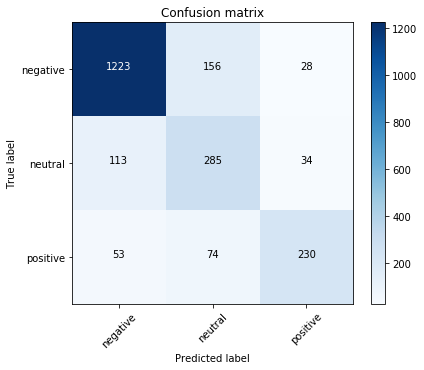

Model Training and Testing time : 1.765213966369629 secs
Model Testing Accuracy : 0.7914389801807091 
Average precision score: 0.85


[0.5181354222401895, 0.7914389801807091]

In [0]:
trained_embeddings = create_embedding_matrix(tk, 100, embeddings)


def c_lstm():
    text_seq_input = Input(shape=(MAX_LEN,), dtype='int32')
    text_embedding = Embedding(NB_WORDS + 1,
                               EMBEDDING_DIM,
                               weights=[trained_embeddings],
                               trainable=True,
                               input_length=MAX_LEN)(text_seq_input)

    filter_sizes = [3, 4, 5, 6, 7]
    convs = []
    for filter_size in filter_sizes:
        l_conv = Convolution1D(
            filters=128,
            kernel_size=filter_size,
            padding='same',
            activation='relu')(text_embedding)
        convs.append(l_conv)

    cnn_feature_maps = concatenate(convs, axis=1)
    sentence_encoder = LSTM(64, return_sequences=False)(cnn_feature_maps)
    fully_connected = Dense(128, activation="relu")(sentence_encoder)
    out = Dense(3, activation="softmax")(fully_connected)
    model = Model(inputs=[text_seq_input], outputs=out)
    model.summary()
    return model


c_lstm_model = c_lstm()
c_lstm_history = train_model(
    c_lstm_model,
    X_train_seq,
    y_train,
    X_valid_seq,
    y_valid)
# test the models
test_model(c_lstm_model, X_test_seq, y_test_one_hot)


## 3.2.18 Experiment 18 AC-BLSTM: Asymmetric Convolutional Bidirectional LSTM Networks for Text Classification

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_27 (InputLayer)           (None, 24)           0                                            
__________________________________________________________________________________________________
embedding_36 (Embedding)        (None, 24, 100)      1000100     input_27[0][0]                   
__________________________________________________________________________________________________
conv1d_107 (Conv1D)             (None, 24, 64)       6464        embedding_36[0][0]               
__________________________________________________________________________________________________
conv1d_109 (Conv1D)             (None, 24, 64)       6464        embedding_36[0][0]               
__________________________________________________________________________________________________
conv1d_111

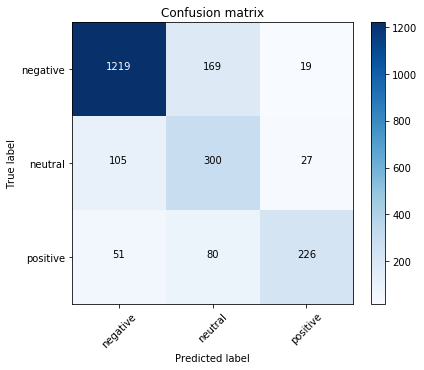

Model Training and Testing time : 0.788815975189209 secs
Model Testing Accuracy : 0.7946265940240607 
Average precision score: 0.86


[0.5128587105452255, 0.7946265940240607]

In [0]:
trained_embeddings = create_embedding_matrix(tk, 100, embeddings)


def ac_bilstm():
    text_seq_input = Input(shape=(MAX_LEN,), dtype='int32')
    text_embedding = Embedding(NB_WORDS + 1,
                               EMBEDDING_DIM,
                               weights=[trained_embeddings],
                               trainable=True,
                               input_length=MAX_LEN)(text_seq_input)

    filter_sizes = [3, 4, 5, 6, 7]
    convs = []
    for filter_size in filter_sizes:
        l_conv1 = Convolution1D(filters=64, kernel_size=1, strides=1,
                                padding="same")(text_embedding)
        l_relu1 = Activation("relu")(l_conv1)
        l_conv2 = Convolution1D(filters=64, kernel_size=filter_size, strides=1,
                                padding="same")(l_relu1)
        l_relu2 = Activation("relu")(l_conv2)
        convs.append(l_relu2)

    l_concat = concatenate(convs, axis=2)
    l_blstm = Bidirectional(
        LSTM(
            32,
            activation="relu",
            return_sequences=True))(l_concat)
    l_dropout = Dropout(0.5)(l_blstm)
    l_flatten = Flatten()(l_dropout)
    l_fc = Dense(128, activation='sigmoid')(l_flatten)
    out = Dense(3, activation="softmax")(l_fc)
    model = Model(inputs=[text_seq_input], outputs=out)
    model.name = 'AC-BILSTM'
    model.summary()
    return model


ac_bilstm_model = ac_bilstm()
ac_bilstm_history = train_model(
    ac_bilstm_model,
    X_train_seq,
    y_train,
    X_valid_seq,
    y_valid)
# test the models
test_model(ac_bilstm_model, X_test_seq, y_test_one_hot)


## 4. Visualization of Layer in CNN

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_31 (InputLayer)           (None, 24)           0                                            
__________________________________________________________________________________________________
embedding_40 (Embedding)        (None, 24, 100)      1000100     input_31[0][0]                   
__________________________________________________________________________________________________
conv1d_129 (Conv1D)             (None, 24, 128)      38528       embedding_40[0][0]               
__________________________________________________________________________________________________
conv1d_130 (Conv1D)             (None, 24, 128)      51328       embedding_40[0][0]               
__________________________________________________________________________________________________
conv1d_131

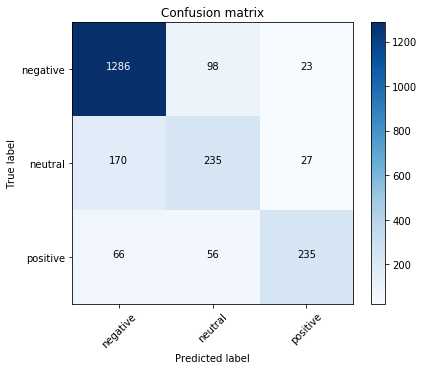

Model Training and Testing time : 0.46454882621765137 secs
Model Testing Accuracy : 0.7996357013836151 
Average precision score: 0.86
2196/2196 [==============================] - 0s 173us/step
Confusion matrix, without normalization
[[1286   98   23]
 [ 170  235   27]
 [  66   56  235]]


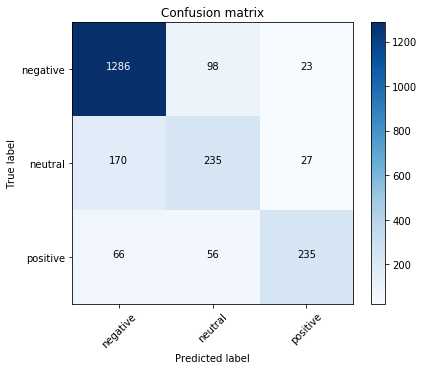

Model Training and Testing time : 0.3969557285308838 secs
Model Testing Accuracy : 0.7996357013836151 
Average precision score: 0.86
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_31 (InputLayer)           (None, 24)           0                                            
__________________________________________________________________________________________________
embedding_40 (Embedding)        (None, 24, 100)      1000100     input_31[0][0]                   
__________________________________________________________________________________________________
conv1d_129 (Conv1D)             (None, 24, 128)      38528       embedding_40[0][0]               
__________________________________________________________________________________________________
conv1d_130 (Conv1D)             (None, 24, 128)      51328       embedding_

In [0]:
# create embedding matrix for the experiment
emb_matrix = create_embedding_matrix(tk, 100, embeddings)


def single_channel_kim_cnn():
    text_seq_input = Input(shape=(MAX_LEN,), dtype='int32')
    text_embedding = Embedding(NB_WORDS + 1,
                               EMBEDDING_DIM,
                               weights=[emb_matrix],
                               trainable=True,
                               input_length=MAX_LEN)(text_seq_input)

    filter_sizes = [3, 4, 5]
    convs = []
    for filter_size in filter_sizes:
        l_conv = Convolution1D(
            filters=128,
            kernel_size=filter_size,
            padding='same',
            activation='relu')(text_embedding)
        l_pool = MaxPooling1D(filter_size)(l_conv)
        convs.append(l_pool)

    merge = concatenate(convs, axis=1)
    convol = Convolution1D(128, 5, activation='relu')(merge)
    pool1 = GlobalMaxPooling1D()(convol)
    dense = Dense(128, activation='relu', name='last_but_one')(pool1)
    out = Dense(3, activation='softmax')(dense)
    model = Model(inputs=[text_seq_input], outputs=out,
                  name="KimSingleChannelCNN-Visualization")
    model.summary()
    return model


single_channel_kim_model = single_channel_kim_cnn()
# train kim's cnn
single_channel_kim_model_history = train_model(
    single_channel_kim_model, X_train_seq, y_train, X_valid_seq, y_valid)
# test the models to see results are same
test_model(single_channel_kim_model, X_test_seq, y_test_one_hot)
# make a copy
single_channel_kim_model_copy = models.clone_model(
    single_channel_kim_model)  # create a copy of Kim's CNN
single_channel_kim_model.set_weights(
    single_channel_kim_model_copy.get_weights())  # transfer the weights
# test the models to see results are same
test_model(single_channel_kim_model, X_test_seq, y_test_one_hot)
# Get rid of the classification layer
single_channel_kim_model_copy.layers.pop()
single_channel_kim_model_copy.outputs = [
    single_channel_kim_model_copy.layers[-1].output]
single_channel_kim_model_copy.layers[-1].outbound_nodes = []
single_channel_kim_model_copy.summary()

# get the hidden features from a layer back
hidden_features = single_channel_kim_model_copy.predict(X_test_seq)


In [0]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# perform PCA on the hidden features
pca = PCA(n_components=30)
pca_result = pca.fit_transform(hidden_features)
print('Variance PCA: {}'.format(np.sum(pca.explained_variance_ratio_)))

# Run T-SNE on the PCA features.
tsne = TSNE(n_components=2, verbose=1)
tsne_results = tsne.fit_transform(pca_result)


Variance PCA: 0.838237464427948
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 2196 samples in 0.003s...
[t-SNE] Computed neighbors for 2196 samples in 0.276s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2196
[t-SNE] Computed conditional probabilities for sample 2000 / 2196
[t-SNE] Computed conditional probabilities for sample 2196 / 2196
[t-SNE] Mean sigma: 0.016886
[t-SNE] KL divergence after 250 iterations with early exaggeration: 76.966713
[t-SNE] Error after 1000 iterations: 2.304199


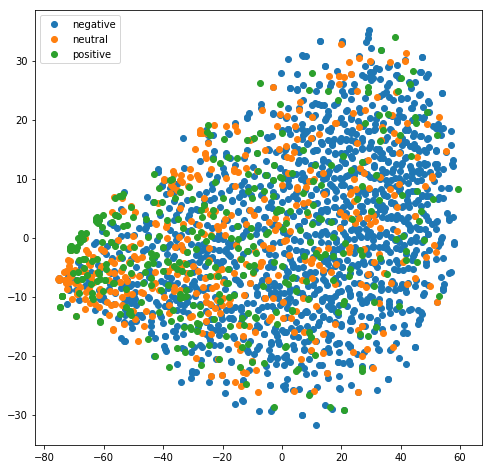

In [0]:
from keras.utils import np_utils
import matplotlib.pyplot as plt
%matplotlib inline

color_map = np.argmax(y_test_one_hot, axis=1)
plt.figure(figsize=(8,8))
for cl in range(3):
    indices = np.where(color_map==cl)
    indices = indices[0]
    plt.scatter(tsne_results[indices,0], tsne_results[indices, 1], label=labels[cl])
plt.legend()
plt.show()

## 5. False Positive and False Negative Analysis 

In [0]:
y_class_index, y_pred_index, confidence,y_softmax = get_predictions_and_confidences(single_channel_kim_model,X_test_seq, y_test_one_hot)
# convert them to data frames
class_series = pd.Series(y_class_index)
class_frame = pd.DataFrame()
class_frame['labels'] = class_series.values
predicted_series = pd.Series(y_pred_index)
predicted_frame = pd.DataFrame()
predicted_frame['predictions'] = predicted_series.values
confidence_series = pd.Series(confidence)
confidence_frame = pd.DataFrame()
confidence_frame['confidence'] = confidence_series.values

# Creating a reverse dictionary
reverse_word_map = dict(map(reversed, tk.word_index.items()))

# Function takes a tokenized sentence and returns the words
def sequence_to_text(list_of_indices):
    # Looking up words in dictionary
    words = [reverse_word_map.get(letter) for letter in list_of_indices]
    return(words)

# Function to convert sentence word index to words
def index_to_sentences(X_test):
    sentences =[]
    for i in range(len(X_test)):
        sequence_string = sequence_to_text(X_test[i])
        while None in sequence_string : sequence_string.remove(None)
        sentence = " ".join(sequence_string)
        sentences.append(sentence)
    return sentences

In [0]:
all_texts = index_to_sentences(X_test_seq)
se = pd.Series(all_texts)
test_data = pd.DataFrame()
test_data['text'] = se.values
all_frames = [test_data,class_frame,predicted_frame,confidence_frame]
predictions_text_labels_frame=pd.concat(all_frames,axis=1)
predictions_text_labels_frame.head()

,text,labels,predictions,confidence
0,thanks it ticket,2,2,0.786337
1,why tell us flight delayed tell us time 20 min...,0,0,0.999105
2,thanks taking back home today despite best eff...,2,2,0.964161
3,tried already amp tried forgetting wifi networ...,0,0,0.999313
4,i'm still trying get things worked yet respond...,0,0,0.973899


## 5.1. False Negative Analysis

In [0]:
pd.set_option('display.max_colwidth', -1)
predictions_text_labels_frame.loc[(predictions_text_labels_frame['labels'] == 2) &
                                  predictions_text_labels_frame['predictions'].isin([1, 0])].sort_values(by=['confidence'])


,text,labels,predictions,confidence
776,i'm sure lot 747 777 jfk lhr flights go lot faster strong,2,1,0.369589
998,where's selfie,2,1,0.391177
257,wanted let know wonderful gate agent working flight ase let know,2,0,0.391668
327,free booze party would make better ord gt msy delayed again we enjoy either way thanks,2,0,0.399639
1022,no worries all y’all good one,2,0,0.399761
1532,chances actually flying charleston today cold weather south places,2,1,0.406321
1967,app reminded flying fll weeks family friends sunshine,2,0,0.408819
1319,anniversary april still lifetime families love,2,0,0.416125
889,course work i'm entire virgin family,2,1,0.416406
86,on flight today rsw grr able free sw agent check me it looks like finally set,2,0,0.420017


## 5.2 False Postive Analysis 

In [0]:
pd.set_option('display.max_colwidth', -1)
predictions_text_labels_frame.loc[(predictions_text_labels_frame['labels'] == 0) &
                                  predictions_text_labels_frame['predictions'].isin([1, 2])].sort_values(by=['confidence'])


,text,labels,predictions,confidence
690,dm'd,0,1,0.381500
1520,,0,1,0.382365
1621,,0,1,0.382365
324,2days,0,1,0.387142
499,left ipad flight den opened claim it many memories it plz help get back,0,1,0.445969
304,upgrade now upgrade what gives http t co,0,1,0.449372
831,that's cool what,0,1,0.458020
1469,never fly us airways again,0,1,0.468252
1086,yes appreciated you may want someone newark,0,1,0.476495
1836,yall sleeping airport 4pm tomorrow thanks,0,1,0.477376


## 6. Model Explainer using Shap

In [0]:
import shap

# we use the first 1000 training examples as our background dataset to
# integrate over
explainer = shap.KernelExplainer(
    single_channel_kim_model.predict, X_train_seq[:1000])
# send the test data
shap_values = explainer.shap_values(X_test_seq[:100], nsamples=100)


Using 1000 background data samples could cause slower run times. Consider using shap.kmeans(data, K) to summarize the background as K weighted samples.
100%|██████████| 100/100 [27:12<00:00, 16.33s/it]


## 6.1 Summary Plot of Feature Vectors 

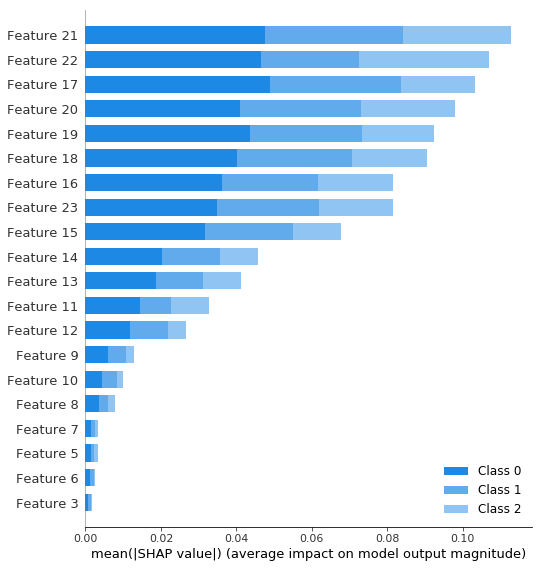

In [0]:
shap.summary_plot(shap_values, X_test_seq[:100])

## 6.2 Visualization of Output and Features per class 


In [0]:
# print the JS visualization code to the notebook
shap.initjs()
# visualize the negaitve tweets
shap.force_plot(explainer.expected_value[0], shap_values[0], X_test_seq[:100])

In [0]:
from lime.lime_text import LimeTextExplainer
explainer = LimeTextExplainer(class_names=TEXT_LABELS)


def new_predict(texts):
    _seq = tk.texts_to_sequences(texts)
    _text_data = pad_sequences(_seq, maxlen=MAX_LEN)
    return single_channel_kim_model.predict(_text_data)


exp = explainer.explain_instance(
    'forget reservations thank great company i have cancelled flighted flight once again thank you',
    new_predict,
    num_features=7,
    labels=[
        0,
        2])

print('Explanation for class %s' % TEXT_LABELS[0])
print('\n'.join(map(str, exp.as_list(label=0))))
print()
print('Explanation for class %s' % TEXT_LABELS[2])
print('\n'.join(map(str, exp.as_list(label=2))))


/Users/udaykamath/anaconda3/lib/python3.6/re.py:212: FutureWarning: split() requires a non-empty pattern match.
  return _compile(pattern, flags).split(string, maxsplit)


Explanation for class negative
('thank', -0.50537272989655)
('great', -0.17526641715684713)
('cancelled', 0.12686752684024252)
('reservations', 0.05703580354068998)
('flighted', -0.056191399841151346)
('company', 0.050136172688808496)
('forget', 0.04556298495453396)

Explanation for class positive
('thank', 0.5683764832998381)
('great', 0.21133810294459318)
('cancelled', -0.11034835677534502)
('flighted', 0.06721269860763154)
('reservations', -0.056832012241528736)
('i', 0.034671828458549804)
('forget', -0.0285069325899802)


In [ ]:
exp.show_in_notebook(text='forget reservations thank great company i have cancelled flighted flight once again thank you', labels=(0,))